In [141]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [143]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [144]:
df = pd.read_excel("/content/drive/MyDrive/Hugo's Portfolio/Introducing NBEATSx to Realized Volatility Forecasting (Research)/DJIA Realized Volatility (NBEATSx).xlsx",index_col='Date',parse_dates=True)


In [145]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'Realised':'y'}, inplace=True)
train = df.iloc[:int(len(df['y'])*0.7)]
test = df.iloc[int(len(df['y'])*0.7)]
validation_length=int(len(df['y'])*0.7)-int(len(df['y'])*0.6)

In [ ]:
n_inputs = [21,63,84,126,189,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs = [100,150,200]
learning_rate=[0.05,0.005,0.0005,0.0001]
num_lr_decays=[10,5,3,5]
dropouts=[0,0.2,0.4]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[80, 90]),DistributionLoss(distribution='StudentT', level=[80, 90])]
RMSE = []
Accuracy = []

# Hyperparameter Search

In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 5046492


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 20241319


Epoch: 200 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: MQLoss() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.05
RMSE: 0.001481093907991667 | Accuracy: 70.52409610922764


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 86999196


Epoch: 150 | Inputs: 252 | MLP units: [[250, 250], [250, 250]] | Loss: DistributionLoss() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.05
RMSE: 762904.4040121819 | Accuracy: -14911538267.027494


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 1976534


Epoch: 100 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: MAE() | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 0.05
RMSE: 0.16012441349794052 | Accuracy: -3112.134317558442


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 41855919


Epoch: 150 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: MSE() | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 0.005
RMSE: 0.0018513208959951974 | Accuracy: 65.86847762871302


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 100 | Inputs: 189 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.05
RMSE: 0.27728963565798553 | Accuracy: -5330.325036609489


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 123594627


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 45912355


Epoch: 150 | Inputs: 252 | MLP units: [[712, 712], [712, 712]] | Loss: MSE() | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001
RMSE: 0.0014412127879977932 | Accuracy: 71.87997333236191


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 117025343


Epoch: 200 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: DistributionLoss() | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005
RMSE: 0.0017601288031899487 | Accuracy: 68.67515576143329


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 127326507


Epoch: 150 | Inputs: 189 | MLP units: [[250, 250], [250, 250]] | Loss: MAE() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.005
RMSE: 0.0018048268116205885 | Accuracy: 68.04663127249438


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 74552245


Epoch: 150 | Inputs: 189 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001
RMSE: 0.0014197453160754595 | Accuracy: 72.92646729530956


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 200 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: DistributionLoss() | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001
RMSE: 0.0014864688625914565 | Accuracy: 71.7765295780177


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 94311439


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 104030342


Epoch: 150 | Inputs: 84 | MLP units: [[100, 100], [100, 100]] | Loss: DistributionLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005
RMSE: 0.001486153911719873 | Accuracy: 72.63196327357022


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 120392794


Epoch: 100 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.05
RMSE: 0.03421856898647742 | Accuracy: -575.9520895926996


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 33145157


Epoch: 200 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: MAE() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.005
RMSE: 0.0018396970896978615 | Accuracy: 66.5999919434965


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 121388468


Epoch: 100 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: MAE() | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0015830638655056721 | Accuracy: 68.73798821113596


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 150 | Inputs: 252 | MLP units: [[250, 250], [250, 250]] | Loss: MQLoss() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005
RMSE: 0.0017346131235577754 | Accuracy: 68.59002932061419


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 93607393


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80825909


Epoch: 200 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001
RMSE: 0.001436243737719873 | Accuracy: 73.8328727357022


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 43620469


Epoch: 150 | Inputs: 252 | MLP units: [[250, 250], [250, 250]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001
RMSE: 0.0013940945930600635 | Accuracy: 73.39890819588537


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 65619982


Epoch: 150 | Inputs: 189 | MLP units: [[100, 100], [100, 100]] | Loss: MAE() | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005
RMSE: 0.0016178056158271733 | Accuracy: 70.57619427210417


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 78245580


Epoch: 200 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: DistributionLoss() | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0018523029733468702 | Accuracy: 66.39355021666398


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 100 | Inputs: 189 | MLP units: [[712, 712], [712, 712]] | Loss: DistributionLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001
RMSE: 0.00146404116018063 | Accuracy: 71.04535381994184


Epoch: 200 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001

In [146]:
df=df[:len(df["y"])-1]

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [ ]:
model = NBEATSx(h=1, input_size=12,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 105645767


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
Accuracy

[64.82374182543363,
 63.62533696922682,
 64.85427385463271,
 64.85480628999589,
 65.76012582096737,
 65.40048955677051,
 65.28256759933075,
 64.68059151676417,
 63.493681340585816,
 65.3718688735575,
 65.80966714627719,
 66.44894096718433,
 65.04245921424719,
 65.25417099357853,
 64.80622983630151]

In [ ]:
RMSE

[0.002485625202201025,
 0.002510085457427686,
 0.002461033147502288,
 0.0024648973503863902,
 0.0024601547619299904,
 0.002449175154297422,
 0.002509135075917493,
 0.0024609584302139643,
 0.0024708637381855403,
 0.0024329270484344722,
 0.002449578937353018,
 0.002478644193917679,
 0.002480197547358453,
 0.002430914150879699,
 0.002474115165530011]

In [ ]:
Quasilikelihood

[0.08870980788600757,
 0.08654418226191668,
 0.08650476747285762,
 0.08650082107597333,
 0.08816479803340427,
 0.0850595367419432,
 0.0953546962540247,
 0.08548102568426987,
 0.08400945980021036,
 0.08535937723377661,
 0.08813969053339821,
 0.09377328284888153,
 0.08845030729025333,
 0.08406582886528904,
 0.08567507726077629]

Text(0, 0.5, 'DJIA Realized Volatility')

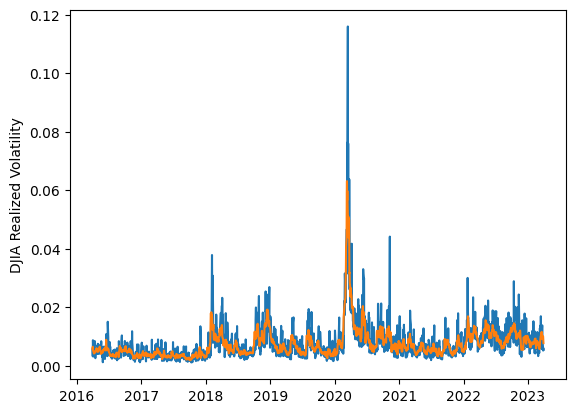

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("DJIA Realized Volatility")

# H=3 Forecasts

In [ ]:
model = NBEATSx(h=3, input_size=12,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=3)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 117050655


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.002432625842037878,
 0.0023946224609703126,
 0.0024059858361667377,
 0.0023648199774880625,
 0.002400933162813723,
 0.00239268608137925,
 0.0023999773116686954,
 0.002373338819600249,
 0.0023718106644891215,
 0.002372914519781926,
 0.0023712659685201642,
 0.002387012126921105,
 0.002368617036604509,
 0.0023780287396373222,
 0.00239547348446014]

In [ ]:
Accuracy

[65.48857364151628,
 66.50508197687478,
 66.81807744546003,
 67.15145079347083,
 65.82410073845384,
 66.63313325617473,
 66.52935338896823,
 66.62429669760482,
 67.23851369072524,
 66.96844660817595,
 67.11390474283827,
 67.44852617690596,
 66.51629488960434,
 66.56472533550138,
 66.23946269873335]

In [ ]:
Quasilikelihood

[0.07963345794365125,
 0.08047714571087526,
 0.08169122055275568,
 0.08042174597407928,
 0.07916789778598805,
 0.07884876092134724,
 0.08214768688021694,
 0.079975632836025,
 0.0787956373855413,
 0.07884798437365713,
 0.07980773748285926,
 0.08243601116274321,
 0.07800066890705032,
 0.07805493554432721,
 0.07899707982067834]

Text(0, 0.5, 'DJIA Realized Volatility')

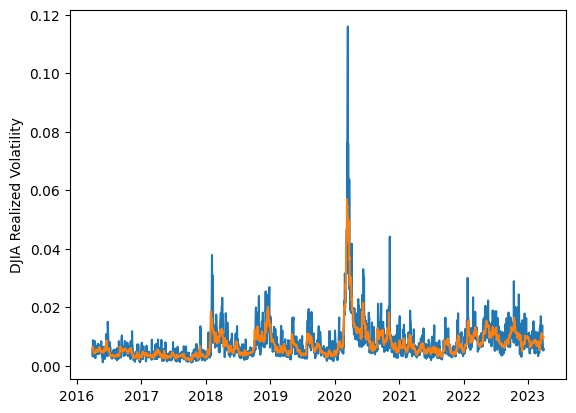

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("DJIA Realized Volatility")

# H=5 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
model = NBEATSx(h=5, input_size=12,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=5)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 29347625


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.0024442553579625847,
 0.0024854305575668784,
 0.0024381568025874196,
 0.0024897920431586652,
 0.0024595382025498487,
 0.0024481679801229986,
 0.002484819254197251,
 0.0025116401701263387,
 0.002447479826591718,
 0.0024219141806798125,
 0.002458067229970028,
 0.002476446675909547,
 0.0024752971167636842,
 0.0024755649527502996,
 0.002442754624389565]

In [ ]:
Accuracy

[65.54510372277977,
 65.20058927107499,
 66.08338463043124,
 64.6002669266344,
 66.7872224529745,
 66.35155767773392,
 64.71059332113525,
 64.96687738115241,
 65.71472740861634,
 65.64592721259842,
 66.07188145852044,
 65.64409798260895,
 65.53524482951211,
 64.68573423051488,
 66.16178304934913]

In [ ]:
Quasilikelihood

[0.08144947458222687,
 0.08488087690890897,
 0.08298312089243896,
 0.08492631552822441,
 0.08614760250683168,
 0.08434278616333858,
 0.08319092967841774,
 0.08522989369345878,
 0.08298056595060949,
 0.07898261283749188,
 0.08483292640608046,
 0.08505576614337039,
 0.08448213358253615,
 0.08265136326115716,
 0.08255377335146201]

Text(0, 0.5, 'DJIA Realized Volatility')

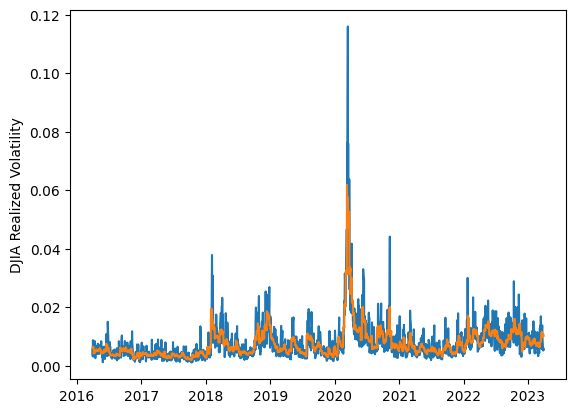

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("DJIA Realized Volatility")

# H=10 Forecasts

In [147]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [148]:
test_length=1750

In [ ]:
model = NBEATSx(h=10, input_size=12,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=10)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 31128630


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.00274176207600335,
 0.0027782024653277967,
 0.0026920210832113104,
 0.0027012665716763195,
 0.002821585272172398,
 0.002715589654724109,
 0.002717831710831911,
 0.002703257268073488,
 0.0026997666712814724,
 0.0026570181879466527,
 0.0027843966166002645,
 0.00277844748522936,
 0.0027462910268220685,
 0.002694565861494331,
 0.002721545937283695]

In [ ]:
Accuracy

[63.28093830812317,
 62.39266954168057,
 63.83763664219882,
 63.36386114133471,
 61.679218975353564,
 63.247151452454744,
 63.48775647661034,
 64.14348186619888,
 64.13689928194586,
 64.62541755122592,
 62.36582971409659,
 62.667580783730045,
 62.603540730797555,
 62.97517317392494,
 63.488700725403625]

In [ ]:
Quasilikelihood

[0.10200828205858045,
 0.10401743165376465,
 0.09927598131061255,
 0.09788737061692311,
 0.10759101691625211,
 0.09992841706538766,
 0.10111785164827679,
 0.10011593095430647,
 0.10150951158643062,
 0.10030770841845908,
 0.10281068743305899,
 0.10637961490395817,
 0.10169998290271359,
 0.0975613318623939,
 0.10095629117793165]

Text(0, 0.5, 'DJIA Realized Volatility')

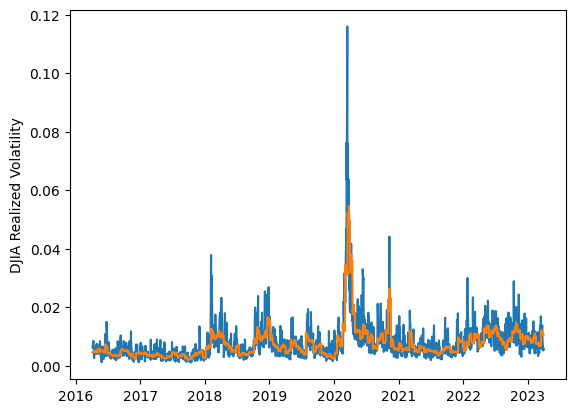

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("DJIA Realized Volatility")

# H=22 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [151]:
test_length=1738

In [ ]:
model = NBEATSx(h=22, input_size=12,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=22,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=22)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 89531417


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.0032510234622717725,
 0.003171573711013363,
 0.0032425993956154667,
 0.0031945851379223075,
 0.003197918075177052,
 0.003217297254617699,
 0.003225897145356832,
 0.0032649052465405187,
 0.0032532289926027534,
 0.00315221967634205,
 0.0032273387290890658,
 0.0032010313982820116,
 0.003254206662461986,
 0.0032207699742287667,
 0.003198847218837946]

In [ ]:
Accuracy

[52.34333167744452,
 54.18006341143729,
 52.510087500662635,
 53.724255785924655,
 53.5787506190833,
 53.743894631694175,
 52.668632774554226,
 51.85345068489758,
 52.03550551377939,
 54.71207947980976,
 53.07685904025563,
 53.8119384299912,
 52.35821879211062,
 53.95158989395217,
 54.24855689739172]

In [ ]:
Quasilikelihood

[0.15966964358793348,
 0.14744621183418674,
 0.15321225962460053,
 0.14973179480388868,
 0.1505642981815178,
 0.15444199811896092,
 0.14808220995755325,
 0.14917743672733874,
 0.15058434884293911,
 0.14792002082846387,
 0.1495979315029998,
 0.1481461901727681,
 0.15277225895620908,
 0.15093111175447677,
 0.14946529388689533]

Text(0, 0.5, 'DJIA Realized Volatility')

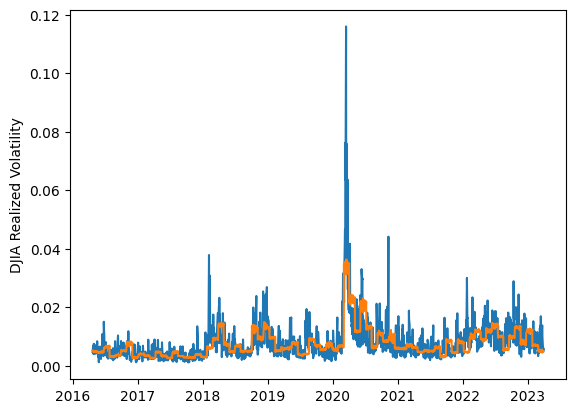

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("DJIA Realized Volatility")